In [1]:
# !pip install import-ipynb

In [2]:
import numpy as np 
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import time
import import_ipynb
import struct
import math
import random

## Dataset

In [3]:
# read the images and labels
def readDataset(dataset):
    (image, label) = dataset
    with open(label, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(image, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    return (img, lbl)

In [4]:
# the path of the dataset
test_image_path = r'../MNIST/t10k-images-idx3-ubyte'
test_label_path = r'../MNIST/t10k-labels-idx1-ubyte'
train_image_path = r'../MNIST/train-images-idx3-ubyte'
train_label_path = r'../MNIST/train-labels-idx1-ubyte'
training_set = (train_image_path, train_label_path)
test_set = (test_image_path, test_label_path)

In [5]:
# read the dataset with readDataset()
(train_image, train_label) = readDataset(training_set)
(test_image, test_label) = readDataset(test_set)
n_m, n_m_test = len(train_label), len(test_label)
print("The shape of training image:", train_image.shape)
print("The shape of testing image: ", test_image.shape)
print("Length of the training set: ", n_m)
print("Length of the training set: ", n_m_test)
print("Shape of a single image: ", train_image[0].shape)

The shape of training image: (60000, 28, 28)
The shape of testing image:  (10000, 28, 28)
Length of the training set:  60000
Length of the training set:  10000
Shape of a single image:  (28, 28)


In [6]:
test_label

array([7, 2, 1, ..., 4, 5, 6], dtype=int8)

### Normalization

In [7]:
# normalization of the input images
def normalize(image):
    image -= image.min()
    image = image / image.max()
    # range = [-0.1,1.175]   
    image = image * 1.275 - 0.1
    return image

In [8]:
def zero_pad(X, pad):
    X_pad = np.pad(X, ((0, ), (pad, ), (pad, ), (0, )), 'constant', constant_values=(0, 0))    
    return X_pad

In [9]:
train_image_normalized_pad = normalize(zero_pad(train_image[:,:,:,np.newaxis], 2))
test_image_normalized_pad  = normalize(zero_pad(test_image[:,:,:,np.newaxis],  2))
print("The shape of training image with padding:", train_image_normalized_pad.shape)
print("The shape of testing image with padding: ", test_image_normalized_pad.shape)

The shape of training image with padding: (60000, 32, 32, 1)
The shape of testing image with padding:  (10000, 32, 32, 1)


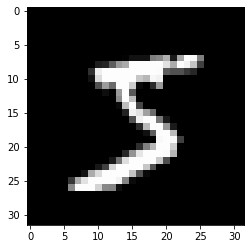

In [10]:
plt.imshow(train_image_normalized_pad[0,:,:,0], cmap = 'gray')

## Lenet

In [11]:
from Model import *

importing Jupyter notebook from Model.ipynb


In [15]:
lenet = Model()
lenet.add(Conv((5,5), 6))
lenet.add(Subsampling(2, Sigmoid()))
lenet.add(Conv((5,5,6), 16))
lenet.add(Subsampling(2))
lenet.add(Conv((5,5,16), 120))
lenet.add(Flatten())
lenet.add(Fully_Connected(84, Tanh(A = 1.7159)))
lenet.add(RBF(10, Tanh(A = 1)))

In [16]:
lenet.compile((32,32,1), (10,1), True)

(32, 32, 1) <Model.Conv object at 0x000001C66F0C2C18>
Output (28, 28, 6)
(28, 28, 6) <Model.Subsampling object at 0x000001C66F0C2630>
Output (14, 14, 6)
(14, 14, 6) <Model.Conv object at 0x000001C66F0C2748>
Output (10, 10, 16)
(10, 10, 16) <Model.Subsampling object at 0x000001C66F0C2710>
Output (5, 5, 16)
(5, 5, 16) <Model.Conv object at 0x000001C66F0C2780>
Output (1, 1, 120)
(1, 1, 120) <Model.Flatten object at 0x000001C66F0C27F0>
Output (120, 1)
(120, 1) <Model.Fully_Connected object at 0x000001C66F0C2898>
Output (84, 1)
(84, 1) <Model.RBF object at 0x000001C66F0C28D0>
Output (10, 1)
The layers fit correctly


In [17]:
lenet.test(train_image_normalized_pad[0:4])

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])